In [106]:
import numpy as np
from urllib.request import urlopen
import scipy.optimize
import random
from sklearn import svm
from sklearn import linear_model
import pandas as pd
import matplotlib.pyplot as plt
import math

def sigmoid(x):
    a = []
    for item in x:
        a.append(1/(1+math.exp(-item)))
    return a


In [6]:
dataDir = "/Users/henryli/Desktop/CSE 258 Rec Sys/cse258/data/"
path = dataDir + "hotel_bookings_clean.csv"
df = pd.read_csv(path)

In [20]:
df.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date'],
      dtype='object')

In [52]:
df['booking_changes']

0        3
1        4
2        0
3        0
4        0
        ..
86935    0
86936    0
86937    0
86938    0
86939    0
Name: booking_changes, Length: 86940, dtype: int64

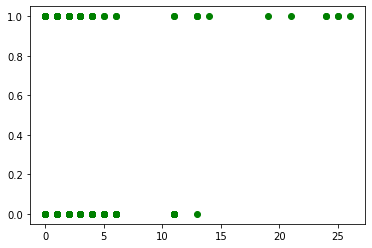

In [56]:
x_prev_cancel = df['previous_cancellations']
y_prev_cancel = df.is_canceled
prev_cancel_avg = [df['previous_cancellations'].mean()] *  y_prev_cancel.size
plt.plot(x_prev_cancel, y_prev_cancel, 'go')
#plt.plot(prev_cancel_avg, y_prev_cancel, 'red')
plt.show()

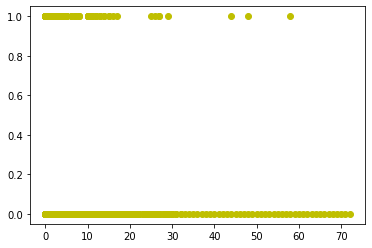

In [58]:
x_prev_not_cancel = df['previous_bookings_not_canceled']
y_label = df.is_canceled
prev_not_cancel_avg = [df['previous_bookings_not_canceled'].mean()] *  y_prev_not_cancel.size
plt.plot(x_prev_not_cancel, y_label, 'yo')
plt.show()

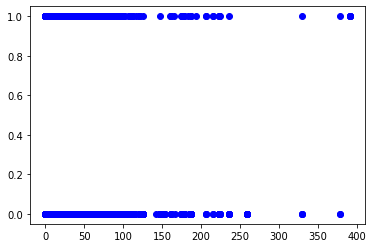

In [62]:
x_waitlist = df['days_in_waiting_list']
y_label = df.is_canceled
prev_not_cancel_avg = [df['days_in_waiting_list'].mean()] *  y_label
plt.plot(x_waitlist, y_label, 'bo')
plt.show()

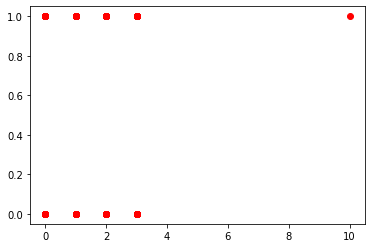

In [63]:
x_children = df['children']
y_labels = df.is_canceled
child_avg = [df['children'].mean()] *  y_labels.size
plt.plot(x_children, y_labels, 'ro')
#plt.plot(lead_time_avg, y_lead_time, 'red')
plt.show()

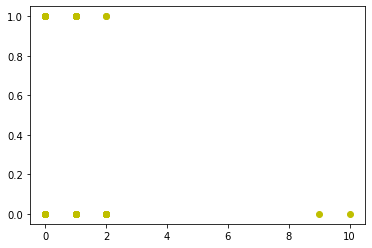

In [70]:
x_babies = df['babies']
y_labels = df.is_canceled
babies_avg = [df['babies'].mean()] *  y_labels.size
plt.plot(x_babies, y_labels, 'yo')
#plt.plot(lead_time_avg, y_lead_time, 'red')
plt.show()

[22979, 982, 26]


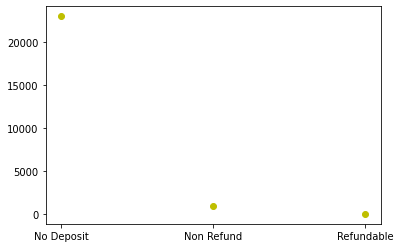

In [88]:
deposit = df.groupby(['deposit_type']).sum()['is_canceled']
x_deposit = ['No Deposit', 'Non Refund', 'Refundable']
y_deposit = [deposit[x] for x in x_deposit]
print(y_deposit)
plt.plot(x_deposit, y_deposit, 'yo')

In [ ]:
#having 2 children is twice as likely to cancel 
group_child = df.groupby(['children']).sum()['is_canceled']
group_child_total =df.groupby(['children']).count()['is_canceled']
print(group_child/group_child_total)
print(group_child_total)

In [97]:
group_dist = df.groupby(['distribution_channel']).sum()['is_canceled']
group_dist_total =df.groupby(['distribution_channel']).count()['is_canceled']
print(group_dist/group_dist_total)

distribution_channel
Corporate    0.129309
Direct       0.148983
GDS          0.198895
TA/TO        0.310106
Undefined    0.000000
Name: is_canceled, dtype: float64


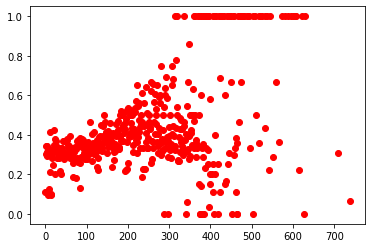

In [123]:
group_lead = df.groupby(['lead_time']).sum()['is_canceled']
group_lead_total =df.groupby(['lead_time']).count()['is_canceled']
prob_cancel_lead_time = np.array(group_lead/group_lead_total)
x_lead_time = pd.unique(df['lead_time'])
y_labels = df.is_canceled
plt.plot(x_lead_time, prob_cancel_lead_time, 'bo')
plt.show()

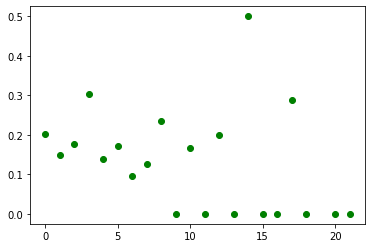

In [124]:
group_book_changes = df.groupby(['booking_changes']).sum()['is_canceled']
group_book_changes_total =df.groupby(['booking_changes']).count()['is_canceled']
prob_cancel_book_changes = np.array(group_book_changes/group_book_changes_total)
x_booking_changes = pd.unique(df['booking_changes'])
y_labels = df.is_canceled
plt.plot(x_booking_changes, prob_cancel_book_changes, 'go')
plt.show()

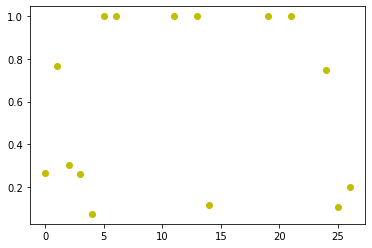

In [126]:
group_prev_cancel = df.groupby(['previous_cancellations']).sum()['is_canceled']
group_prev_cancel_total =df.groupby(['previous_cancellations']).count()['is_canceled']
prob_cancel_prev_cancel = np.array(group_prev_cancel/group_prev_cancel_total)
x_prev_cancel = pd.unique(df['previous_cancellations'])
y_labels = df.is_canceled
plt.plot(x_prev_cancel, prob_cancel_prev_cancel, 'yo')
plt.show()


In [127]:
group_prev_cancel/group_prev_cancel_total

previous_cancellations
0     0.268017
1     0.765004
2     0.302752
3     0.262295
4     0.200000
5     0.105263
6     0.117647
11    0.074074
13    0.750000
14    1.000000
19    1.000000
21    1.000000
24    1.000000
25    1.000000
26    1.000000
Name: is_canceled, dtype: float64

In [128]:
prob_cancel_prev_cancel


array([0.2680167 , 0.76500362, 0.30275229, 0.26229508, 0.2       ,
       0.10526316, 0.11764706, 0.07407407, 0.75      , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ])